# A nonlinear perspective on climate change

<p class="gap2"></p>

The following lab will have you explore the concepts developed in [Palmer (1999}](https://www.researchgate.net/publication/235703704_A_Nonlinear_Dynamical_Perspective_on_Climate_Prediction)


## 1. Exploring the Lorenz System

By now you are well acquainted with the *Lorenz system:*

$$
\begin{aligned}
\dot{x} & = \sigma(y-x) \\
\dot{y} & = \rho x - y - xz \\
\dot{z} & = -\beta z + xy
\end{aligned}
$$


It exhibits a range of different behaviors as the parameters ($\sigma$, $\beta$, $\rho$) are varied.

Wouldn't it be nice if you could tinker with this yourself? That is exactly what you will be doing in this lab.

Everything is based on the programming language [Python](https://www.python.org/), which every geoscientist [should learn](http://earthpy.org/tag/python-for-geosciences.html). But all you need to know is that Shit+Enter will execute the current cell and move on to the next one. For all the rest, read [this](http://nbviewer.ipython.org/github/ipython/ipython/blob/1.x/examples/notebooks/Part%201%20-%20Running%20Code.ipynb)



*Note that if you're viewing this notebook statically (e.g. on nbviewer) the examples below will not work. They require connection to a running Python kernel*

Let us start by defining a few useful modules

In [35]:
%matplotlib inline
import numpy as np
from scipy import integrate

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import cnames
from matplotlib import animation
import seaborn as sns
import butter_lowpass_filter as blf


### Let's write a quick Lorenz solver

In [51]:
def solve_lorenz(N=10, angle=0.0, max_time=4.0, sigma=10.0, beta=8./3, rho=28.0):
    
    def lorenz_deriv((x, y, z), t0, sigma=sigma, beta=beta, rho=rho):
        """Compute the time-derivative of a Lorentz system."""
        return [sigma * (y - x), x * (rho - z) - y, x * y - beta * z]

    # Choose random starting points, uniformly distributed from -15 to 15
    np.random.seed(1)
    x0 = -15 + 30 * np.random.random((N, 3))

    # Solve for the trajectories
    t = np.linspace(0, max_time, int(250*max_time))
    x_t = np.asarray([integrate.odeint(lorenz_deriv, x0i, t)
                      for x0i in x0])
    
    # choose a different color for each trajectory
    colors = plt.cm.jet(np.linspace(0, 1, N))

    # plot the results
    sns.set_style("white")
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_axes([0, 0, 1, 1], projection='3d')
    #ax.axis('off')

    # prepare the axes limits
    ax.set_xlim((-25, 25))
    ax.set_ylim((-35, 35))
    ax.set_zlim((5, 55))

    for i in range(N):
        x, y, z = x_t[i,:,:].T
        lines = ax.plot(x, y, z, '-', c=colors[i])
        plt.setp(lines, linewidth=1)

    ax.view_init(30, angle)
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    plt.show()

    return t, x_t

### Let's plot this solution 

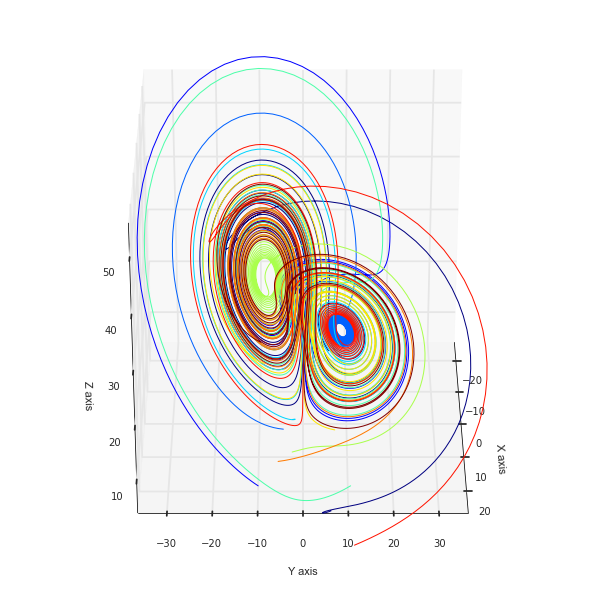

In [52]:
t, x_t = solve_lorenz(max_time=10.0)

Very pretty. If you are curious, you can even change the plot angle within the function, and examine this strange attractor under all angles. There are several key properties to this attractor:


## A forced Lorenz system ##

As a metaphor for anthropogenic climate change, we now consider the case of a forced lorenz system. We wish to see what happens if a force  is applied in the directions $X$ and $Y$.   The magnitude of this force is $f_0$ and we may apply it at some angle $\theta$. Hence:

$f = f_0 \left ( \cos(\theta),sin(\theta) \right) $

The new system is thus:

$$
\begin{aligned}
\dot{x} & = \sigma(y-x) + f_0  \cos(\theta)\\
\dot{y} & = \rho x - y - xz +  f_0  \sin(\theta)\\
\dot{z} & = -\beta z + xy
\end{aligned}
$$

Does the attractor change? Do the solutions change? If so, how?


### Solving the system ###
Let us define a function to solve this new system:

In [53]:
def forced_lorenz(N=3, fnot=2.5, theta=0, max_time=100.0, sigma=10.0, beta=8./3, rho=28.0):
    
    def lorenz_deriv((x, y, z), t0, sigma=sigma, beta=beta, rho=rho):
        """Compute the time-derivative of a forced Lorentz system."""
        c = 2*np.pi/360
        return [sigma * (y - x) + fnot*np.cos(theta*c), x * (rho - z) - y + fnot*np.sin(theta*c), x * y - beta * z]

    # Choose random starting points, uniformly distributed from -15 to 15
    np.random.seed(1)
    x0 = -15 + 30 * np.random.random((N, 3))

    # Solve for the trajectories
    t = np.linspace(0, max_time, int(25*max_time))
    x_t = np.asarray([integrate.odeint(lorenz_deriv, x0i, t)
                      for x0i in x0])
    return t, x_t
    

Let's start by plotting the solutions for X, Y and Z when $f_0 = 0$ (no pertubation):

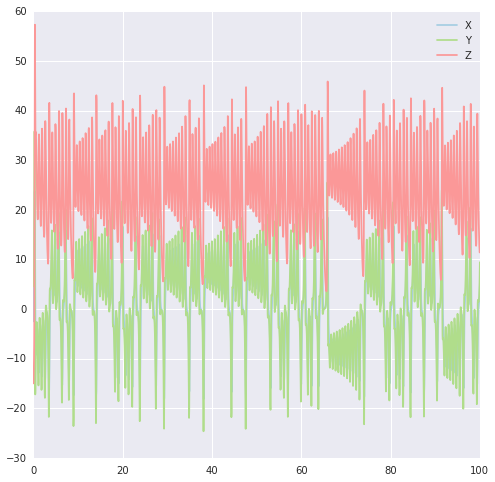

In [55]:
sns.set_style("darkgrid")
sns.set_palette("Dark2")    
t, x_t = forced_lorenz(fnot = 0, theta = 50,max_time = 100.00)

xv = x_t[0,:,:]
# time filter
lab = 'X', 'Y', 'Z'

col = sns.color_palette("Paired")

fig = plt.figure(figsize = (8,8))
xl = np.empty(xv.shape)
for k in range(3):
     xl[:,k] = blf.filter(xv[:,k],0.5,fs=25) 
     plt.plot(t,xv[:,k],color=col[k*2])
     #plt.plot(t,xl[:,k],color=col[k*2+1],lw=3.0)

plt.legend(lab)
plt.show()


What happened to X? Well in this case X and Y are so close to each other that they plot on top of each other. 
Baiscally, the system orbits around some fixed points near $X, Y = \pm 10$. The transitions between these "regimes" are quite random. Sometimes the system hangs out there a while, sometimes not. 

### Isolating climate fluctuations ###

Furthermore, you may be overwhelmed by the short term variability in the system. In the climate system, we call this shprt-term variability "weather", and often what is of interest is the long-term behavior of the system (the "climate"). To isolate that, we need to **filter** the solutions. More precisely, we will apply a butterworth lowpass filter to $X, Y ,Z$ to highlight their slow evolution. (if you ever wonder what it is, take GEOL425L: Data Analysis in the Earth and Environmental Sciences)

(0, 100)

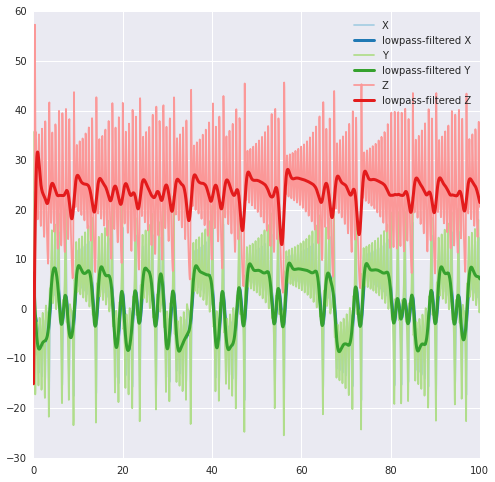

In [62]:
# Timeseries PLOT    
sns.set_palette("Dark2")    
t, x_t = forced_lorenz(fnot = 0, theta = 50,max_time = 1000.00) 

xv = x_t[0,:,:]
# time filter
lab = 'X', 'lowpass-filtered X', 'Y', 'lowpass-filtered Y', 'Z','lowpass-filtered Z' 

col = sns.color_palette("Paired")

fig = plt.figure(figsize = (8,8))
xl = np.empty(xv.shape)
for k in range(3):
     xl[:,k] = blf.filter(xv[:,k],0.5,fs=25) 
     plt.plot(t,xv[:,k],color=col[k*2])
     plt.plot(t,xl[:,k],color=col[k*2+1],lw=3.0)

plt.legend(lab)
plt.xlim(0,100)

# Be patient... this could take a few seconds to complete.

(Once again, Y is on top of X. )


Let us now plot the probability of occurence of states in the $(X,Y)$ plane. If all motions were equally likely, this probability would be uniform. Is that what we observe?

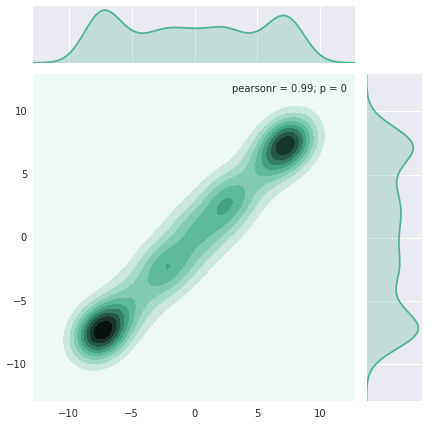

In [64]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
skip = 10
sns.jointplot(xl[0::skip,0],xl[0::skip,1], kind="kde", color="#4CB391")

### Question 1 ### 

How would you describe the probability of visiting states? What do "dark" regions correspond to?


### Answer 1:

Write your answer here

## 2. Visualizing climate change in the Lorenz system 

We now wish to see if this changes once we apply a non-zero forcing. Specifically:
1. Does the attractor change with the applied forcing?
2. If not, can we say something about how frequently some states are visited?

In all the following we set $f_0 = 2.5$ and we tweak $\theta$ to see how the system responds 


To ease experimentation, let us first define a function to compute and plot the results:

In [73]:
def plot_lorenzPDF(fnot, theta, max_time = 1000.00, skip = 10):
    t, x_t = forced_lorenz(fnot = fnot, theta = theta,max_time = max_time)
    xv = x_t[0,:,:]; xl = np.empty(xv.shape)

    for k in range(3):
        xl[:,k] = blf.filter(xv[:,k],0.5,fs=25) 

    g = sns.jointplot(xl[0::skip,0],xl[0::skip,1], kind="kde", color="#4CB391")
    return g


### Now let's have some fun 



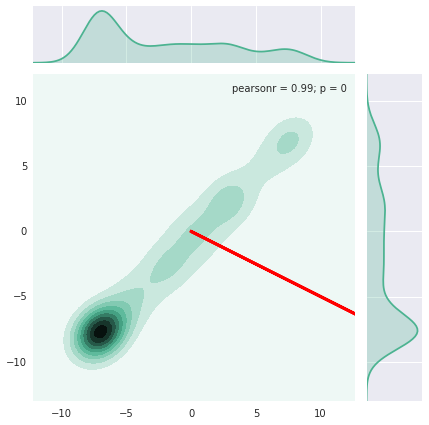

In [82]:
theta = 50; f0 = 2.5 # assign values of f0 and theta
g = plot_lorenzPDF(fnot = f0, theta = theta)  
g.ax_joint.arrow(0, 0, 2*f0*np.cos(theta*np.pi/180), f0*np.sin(theta*np.pi/180), head_width=0.5, head_length=0.5, lw=3.0, fc='r', ec='r')

## (BE PATIENT THIS COULD TAKE UP TO A MINUTE) 

(the forcing is marked by a red arrow)

### Question 2.1 : What do you observe for $\theta = 50^{\circ}$?


### Answer 2.1:

Write your answer here


### Question 2.2 : What do you observe for $\theta = 140^{\circ}$?

(is it counter-intuitive? Welcome to the wonderful world of chaos theory)
compute and plot here:

### Answer 2.2:

Write your answer here


### Question 2.3 : What do you observe for $\theta = 225^{\circ}$?


compute and plot here:

### Answer 2.3:

Write your answer here


### Question 2.4 : What do you observe for $\theta = -45^{\circ}$?

compute and plot here

### Answer 2.4:

write your answer here

### Question 2.5 : Repeat one of the experiments above, with  $f_0 = 10$?

compute and plot here



### Answer 2.5:

write your answer here

(for fun , you may try $f_0 = 25$. What happens then?)


To conclude, comment on the first 2 principles enunciated by Palmer (1999):
*"First, the response to a forcing will be manifest primarily in terms of changes to the residence frequency associated with the quasi-stationary regimes. Second, the [...] structures of these regimes will be relatively insensitive to the forcing (within limits)." *


### Question 3 :  Is this what you observed within this toy model?  Assuming that Earth's climate follows similar dynamics, what would be the best way to deciding whether climate change is happening or not?

### Answer 3:

write your answer here